# Model A

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [229]:
r = h5py.File('./data/N32/outputN32dt0005H0_01.h5','r')
r = h5py.File('./output.h5','r')
print(list(r.keys()))
phi=np.asarray(r["phi"])

['phi', 'phidot', 'wallX_phi_0', 'wallX_phi_1', 'wallX_phi_2', 'wallX_phi_3', 'wallX_phi_4', 'wallX_phidot_0', 'wallX_phidot_1', 'wallX_phidot_2', 'wallX_phidot_3', 'wallX_phidot_4']


In [168]:
r["phi"][0]

array([0.16971794, 0.03486304, 0.05022888, 0.03803493, 0.93189395])

In [165]:
np.sum(r["wallY_phi_0"][0])/16.0

KeyError: "Unable to open object (object 'wallY_phi_0' doesn't exist)"

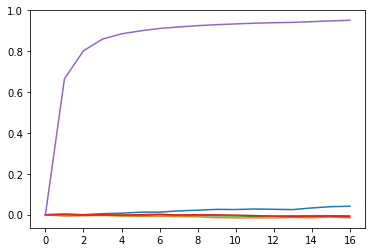

In [230]:
plt.plot(r["phi"])
#plt.ylim([2,2.5])

In [201]:
import random


class ConfResults:
    def __init__(self,fn, thTime , decim):
        self.fn = fn
        self.thTime = thTime
        self.decim = decim

    def readAv(self):
        r = h5py.File(self.fn,'r')
        self.phi = np.asarray(r["phi"])[self.thTime:]
        self.phidot = np.asarray(r["phidot"])[self.thTime:]
        self.phiNorm = self.phi[:,-1]
        self.phidotNorm = self.phidot[:,-1]
    
    def computeMag(self, direc = 0):
        self.readAv()
        self.mag, self.magErr = bootstrap(self.phi[:,direc],100) 
    def computePhiDot(self, direc = 0):
        self.readAv()
        self.avPhiDot, self.errPhiDot = bootstrap(self.phidot[:,direc],100) 
        
    def wallXFourierNorm(self):
        r = h5py.File(self.fn,'r')
        #self.wallXphi = np.asarray([np.asarray(r["wallX_phi_0"])[thTime:],np.asarray(r["wallX_phi_1"])[thTime:],np.asarray(r["wallX_phi_2"])[thTime:],np.asarray(r["wallX_phi_3"])[thTime:]])
        self.wallXphiNorm = np.asarray(r["wallX_phi_4"])[self.thTime:]
        Nx = len(self.wallXphiNorm[0])
        ks = [2 * np.pi * i /float(Nx) for i in range(Nx)]
        self.wallXphiNormF = np.zeros(np.shape(self.wallXphiNorm), dtype=complex)
        for t in range(len(self.wallXphiNorm)):
            self.wallXphiNormF[t] = np.fft.fft(self.wallXphiNorm[t])
            #self.wallXphiNormF[t] = self.manualFourier(self.wallXphiNorm[t])
    
    def wallXFourier0(self):
        r = h5py.File(self.fn,'r')
        #self.wallXphi = np.asarray([np.asarray(r["wallX_phi_0"])[thTime:],np.asarray(r["wallX_phi_1"])[thTime:],np.asarray(r["wallX_phi_2"])[thTime:],np.asarray(r["wallX_phi_3"])[thTime:]])
        self.wallXphi0 = np.asarray(r["wallX_phi_0"])[self.thTime:]
        Nx = len(self.wallXphi0[0])
        ks = [2 * np.pi * i /float(Nx) for i in range(Nx)]
        self.wallXphi0F = np.zeros(np.shape(self.wallXphi0), dtype=complex)
        for t in range(len(self.wallXphi0)):
            self.wallXphi0F[t] = np.fft.fft(self.wallXphi0[t])
            #self.wallXphiNormF[t] = self.manualFourier(self.wallXphiNorm[t])
        
    def computeCttp(self, arr1, arr2, conn=False):
        Npoints = len(arr1)
        Cttp = np.zeros(Npoints, dtype=type(arr1[0]))
        for tt in range(Npoints): #tt is the time difference
            for t0 in range(0, Npoints - tt, self.decim): # t0 is the origin
                Cttp[tt] += arr1[t0 + tt] * arr2[t0] 
                if conn:
                  Cttp[tt] -= arr1[t0]*arr2[t0]
            Cttp[tt]/=float(Npoints - tt)
        return Cttp
    
    def computeCttpPhi(self):
        self.CttpPhi = self.computeCttp(self.phiNorm, self.phiNorm)
    def computeCttpPhidot(self):
        self.CttpPhidot = self.computeCttp(self.phidotNorm, self.phidotNorm)
    def computeCttpPhiPhidot(self):
        self.CttpPhiPhidot = self.computeCttp(self.phiNorm, self.phidotNorm)
    
    # For testing purposes
    def manualFourier(self, arr):
        Nx = len(arr)
        ks = [2 * np.pi * i /float(Nx) for i in range(Nx)]
        arrF = np.zeros(Nx, dtype=complex)
        for k in range(Nx):
            for x in range(Nx):
                arrF[k] += arr[x] * np.exp(-1j * x * ks[k] )
    
        return arrF
    
def bootstrap(arr, nSamples=100):
    arr = np.asarray(arr)
    #random.seed()
    #bootstrapArr = []
    #for n in range(nSamples):
    #    newArr = np.zeros(np.shape(arr), dtype=arr.dtype)
    #    for l in range(len(arr)):
    #        newArr[l] = arr[random.randrange(0,len(arr))]
    #    bootstrapArr.append(np.mean(newArr,axis = 0))
    #
    #bootstrapArr = np.asarray(bootstrapArr)
    
    #return (np.mean(bootstrapArr,axis = 0), np.std(bootstrapArr,axis = 0))
    return (np.mean(arr,axis = 0), np.std(arr,axis = 0))
    

class EnsembleResults:
    def __init__(self,fn, nEnd, nStart=0):
        self.fnList = [fn +"_"+str(i)+".h5" for i in range(nStart,nEnd+1)]
        self.nConf = nEnd-nStart+1
    
    def corFourierPhi(self, nTherm, nBoot, decim):
        corrTot = []
        for fn in self.fnList:
            res = ConfResults(fn, nTherm,decim)
            print(fn)
            res.wallXFourierNorm()
            Nx = len(res.wallXphiNormF[0])
            corrTot.append([res.computeCttp(np.conj(res.wallXphiNormF[:,k]),res.wallXphiNormF[:,k]) for k in range(Nx)])
            print(len(corrTot[-1][0]))
            
        self.corFourierPhiMean, self.corFourierPhiErr  = bootstrap(corrTot, nBoot)
    def save(self, fn):
            np.savetxt(fn,[self.corFourierPhiMean, self.corFourierPhiErr])

In [83]:
testManu = res.manualFourier(res.wallXphiNorm[2])
testauto = np.fft.fft(res.wallXphiNorm[2])
print(testManu)
print(testauto)

[ 2.56160799e+01+0.00000000e+00j -8.86368577e-02-6.12267668e-02j
  9.25191244e-02-3.04928488e-02j  1.01719903e-01+6.17417601e-03j
 -1.54372650e-01+1.45564770e-01j -4.23818508e-02+3.65530791e-02j
 -1.68795429e-01-2.42254753e-02j  9.40541357e-03+7.28437315e-02j
 -6.18189194e-02-7.80445642e-15j  9.40541357e-03-7.28437315e-02j
 -1.68795429e-01+2.42254753e-02j -4.23818508e-02-3.65530791e-02j
 -1.54372650e-01-1.45564770e-01j  1.01719903e-01-6.17417601e-03j
  9.25191244e-02+3.04928488e-02j -8.86368577e-02+6.12267668e-02j]
[ 2.56160799e+01+0.j         -8.86368577e-02-0.06122677j
  9.25191244e-02-0.03049285j  1.01719903e-01+0.00617418j
 -1.54372650e-01+0.14556477j -4.23818508e-02+0.03655308j
 -1.68795429e-01-0.02422548j  9.40541357e-03+0.07284373j
 -6.18189194e-02+0.j          9.40541357e-03-0.07284373j
 -1.68795429e-01+0.02422548j -4.23818508e-02-0.03655308j
 -1.54372650e-01-0.14556477j  1.01719903e-01-0.00617418j
  9.25191244e-02+0.03049285j -8.86368577e-02+0.06122677j]


In [48]:
res = EnsembleResults('./data/N16_tests/seaw/run40n', 18,14)
res.corFourierPhi(200,10,10)


./N16_tests/seaw/run40n_14.h5
9801
./N16_tests/seaw/run40n_15.h5
9801
./N16_tests/seaw/run40n_16.h5
9801
./N16_tests/seaw/run40n_17.h5
9801
./N16_tests/seaw/run40n_18.h5
9801


In [191]:
lRes = []
lResErr = []

for i in range(1):
    res = ConfResults('./data/N32/outputN32dt0005H0_01.h5',40000,100)
    res.computeMag(i)
    lRes.append(res.mag)
    lResErr.append(res.magErr)
    


In [192]:
lResErr

[5.249556804618974e-05]

In [177]:
20000*0.005

100.0

In [198]:
fns=["outputN32dt00003H0_01", "outputN32dt0001H0_01", "outputN32dt0005H0_01", "outputN32dt001H0_01", "outputN32dt005H0_01"]

resMag=[]
resMagErr=[]
dts = [0.0003, 0.001, 0.005, 0.01, 0.05]

for i  in range(len(fns)):
    res = ConfResults("./data/N32/"+fns[i]+".h5",20000,10)
    res.computeMag(0)
    res.computePhiDot(0)
    resMag.append(res.mag)
    resMagErr.append(res.magErr)

In [199]:
resMag

[0.32812981295029203,
 0.3260695351863463,
 0.3296509470948854,
 0.35448547740974357,
 0.5183050415226178]

In [98]:
fns=["outputN32dt0001H0_001", "outputN32dt0005H0_001", "outputN32H0_001"]

resMag=[]
resMagErr=[]
dts = [0.001, 0.005, 0.01]

for fn in fns:
    res = ConfResults("./data/N32/"+fn+".h5",20000,10)
    res.computeMag(0)
    res.computePhiDot(0)
    resMag.append(res.mag)
    resMagErr.append(res.magErr)

In [61]:
tmp.reverse()

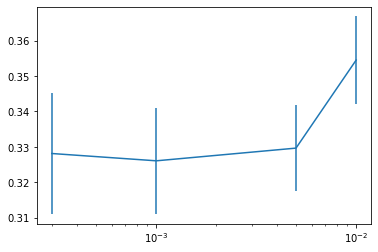

In [200]:
plt.errorbar(dts[:-1], resMag[:-1],resMagErr[:-1])
plt.xscale('log')

In [202]:
res = ConfResults('./data/N32/outputN32dt0005H0_01.h5', 20000,10)

In [207]:
res.wallXFourier0()
test=res.computeCttp(np.conj(res.wallXphi0F[:,1]),res.wallXphi0F[:,1])

In [190]:
mean, err = bootstrap(res.corrTot,5)

In [152]:
np.shape(mean)

(16, 301)

In [113]:
res.wallXFourier()

In [116]:
test=res.computeCttp(np.conj(res.wallXphiNormF[:,1]),res.wallXphiNormF[:,1])

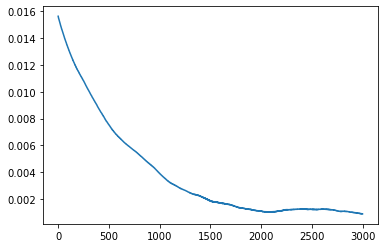

In [214]:
plt.plot(np.real(test)[:3000])

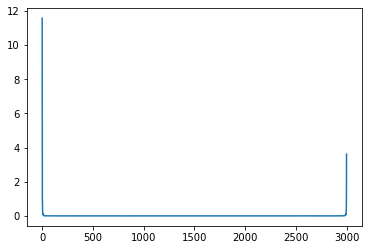

In [220]:
plt.plot(np.real(np.fft.fft(np.real(test)[:3000])))

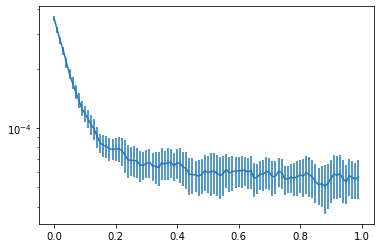

In [33]:
end=100
dt = 0.01
t = np.arange(len(res.corFourierPhiMean[1][0:end])) * dt
plt.errorbar(t,np.real(res.corFourierPhiMean[1][0:end]),np.real(res.corFourierPhiErr[1][0:end]))
plt.yscale('log')

In [61]:
fft[:int(len(fft)/2)]
np.asarray(fft[int(len(fft)/2+1):]).flip()

AttributeError: 'numpy.ndarray' object has no attribute 'flip'

In [52]:
fft=np.fft.fft(res.corFourierPhiMean[4][0:100])
fft=np.concatenate(fft[:int(len(fft)/2)],fft[-1:int(len(fft)/2+1)])

TypeError: only integer scalar arrays can be converted to a scalar index

In [32]:
print(res.wallXphi[0][0])
print(res.wallXphi[1][0])
print(res.wallXphi[2][0])
print(res.wallXphi[3][0])

[ 0.03980615  0.00921391  0.00448425 -0.00629541  0.13847117  0.18007944
  0.18124877  0.25109351  0.27025765  0.22871868  0.28205302  0.18860907
  0.0910679   0.11848171  0.03691116  0.03114464]
[0.06629917 0.13449335 0.22304684 0.33576112 0.3886682  0.38745133
 0.39043144 0.32277384 0.20377822 0.18944155 0.22025963 0.20037172
 0.20758677 0.17045621 0.1095648  0.15142416]
[-1.97070256 -1.96663464 -1.95699276 -1.92538197 -1.93809525 -2.05809571
 -2.00253098 -2.02835163 -2.04785177 -2.06632884 -2.12208639 -2.15115059
 -2.09956571 -2.02178736 -1.96218925 -1.99521995]
[-1.81456117 -1.79362135 -1.76388443 -1.82248324 -1.82312704 -1.69377328
 -1.71348992 -1.68470556 -1.72449619 -1.66984524 -1.5642932  -1.56867645
 -1.65756129 -1.74702555 -1.80289948 -1.74809884]


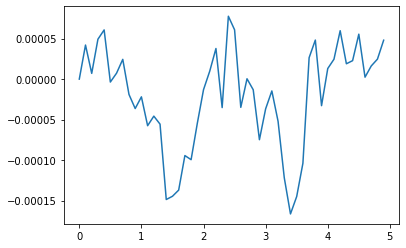

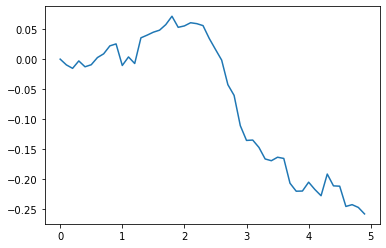

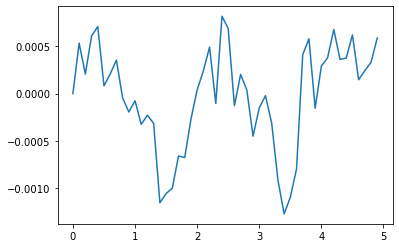

In [42]:
res = Results('./N16_tests/outputN16_1.h5',200)
res.computeCttpPhi()
res.computeCttpPhidot()
res.computeCttpPhiPhidot()

end =50
dt = 0.1
t = np.arange(len(res.CttpPhi[:end])) * dt
plt.figure(0)
plt.plot(t,res.CttpPhi[:end])
plt.figure(1)
plt.plot(t,res.CttpPhidot[:end])
plt.figure(2)
plt.plot(t,res.CttpPhiPhidot[:end])
plt.show()

In [7]:
!cat input.in

#Magnetic field
H = 0.01

#Lattice size
NX = 16
NY = 16
NZ = 16

#Lattice length L = N dx
LX = 15
LY = 15
LZ = 15

#N in O(N)
Ndof = 4


#Times and timestep
finaltime = 50
initialtime = 0
deltat    = 0.01
saveFreq = 0.1

#Parameters
mass = -10
lambda  = 1.25
gamma  = 1

# Set to 0 or don't pass to have a random seed
#seed = 12235456


#output tag
output = output
